## Model the transmission of light from a crystal

This assumes the light comes from a point source and bounces off the walls of the crystal. 

By counting bounces from all the faces, for an initial emission angle $\theta$, and summing the infinite series, the total power emitted out the left face is

$$ P_L(\theta) = \frac{(1-R)R^{w|\tan\theta|/2}}{1 - R^{2 + 2w|\tan\theta|}} \times \left\{
\begin{array}[ll]
 RR^{1 + w|\tan\theta|} & |\theta| < \pi/2\\
1 & |\theta| > \pi/2
\end{array} \right.
$$

where $w$ is the ratio of the width to the height of the crystal, and $R$ is the (assumed constant) reflection coefficient.

The flux from the other faces is determined by offsetting $\theta$ as appropriate, and setting $w \rightarrow 1/w$.

Taking $R = 1 - \epsilon$ where $\epsilon$ is small, gives the approximations

$$ P_L(\theta) = \frac{1}{2 + 2w|\tan\theta|} \times \left\{
\begin{array}[ll]
11 - 3/2\cdot w|\tan\theta|\epsilon & |\theta| < \pi/2\\
1 - 1/2\cdot w|\tan\theta|\epsilon & |\theta| > \pi/2
\end{array} \right.
$$

so taking $\epsilon \rightarrow 0$, one has the fraction of light $F_L$

$$F_L(w) = \frac{1}{2\pi}\int_0^{2\pi} \frac{1}{2 + 2w|\tan\theta|}\,d\theta = \frac{1 + \frac{4}{\pi}w\log w }{2 + 2w^2}$$

which gives the limits

$$ F_L(w) = \left\{
\begin{array}[ll]
11/4 & w \rightarrow 1\\
\frac{2}{\pi}\frac{\log w}{w} & w \rightarrow \infty
\end{array} \right.
$$

In [382]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [383]:
def simulateCrystal(thetas, R, w, plotflag=1):
    totalpowerL = np.zeros_like(thetas)
    totalpowerR = np.zeros_like(thetas)
    totalpowerU = np.zeros_like(thetas)
    totalpowerD = np.zeros_like(thetas)
    
    if plotflag:
        f, ax = plt.subplots()
    else:
        f = None
    cols = plt.get_cmap('magma').colors
    Ncols = len(cols)

    for ith, theta0 in enumerate(thetas):
        x0, y0 = 0, 0
        power = 1.0
        powerleft = []
        powerright = []
        powerup = []
        powerdown = []
        if plotflag:
            colind = int((Ncols-1)*float(ith+1)/float(len(thetas)))
            col = cols[colind]
            col = sns.color_palette()[ith]

        dt = 0.05
        x, y = x0, y0
        theta = theta0
        
        Nsteps = 20000

        for i in range(Nsteps):
            x += dt*np.cos(theta)
            y += dt*np.sin(theta)

            if y > 1.0:
                powerup.append((1-R)*power)
                y = 1.0
                power *= R
                x1 = x
                y1 = y
                if plotflag:
                    ax.plot([x, x+100*np.cos(theta)], [y, y+100*np.sin(theta)], alpha=power*(1-R)/R, c=col)
                    ax.plot([x0, x1], [y0, y1], alpha=power/R, c=col)
                x0, y0 = x1, y1
                theta = -theta
            if y < -1.0:
                powerdown.append((1-R)*power)
                power *= R
                x1 = x
                y1 = y
                if plotflag:
                    ax.plot([x, x+100*np.cos(theta)], [y, y+100*np.sin(theta)], alpha=power*(1-R)/R, c=col)
                    ax.plot([x0, x1], [y0, y1], alpha=power/R, c=col)
                x0, y0 = x1, y1
                theta = -theta
            if x > w:
                powerright.append((1-R)*power)
                x = w
                power *= R
                x1 = x
                y1 = y
                if plotflag:
                    ax.plot([x, x+100*np.cos(theta)], [y, y+100*np.sin(theta)], alpha=power*(1-R)/R, c=col)
                    ax.plot([x0, x1], [y0, y1], alpha=power/R, c=col)
                x0, y0 = x1, y1
                theta = np.pi - theta
            if x < -w:
                powerleft.append((1-R)*power)
                x = -w
                power *= R
                x1 = x
                y1 = y
                if plotflag:
                    ax.plot([x, x+100*np.cos(theta)], [y, y+100*np.sin(theta)], alpha=power*(1-R)/R, c=col)
                    ax.plot([x0, x1], [y0, y1], alpha=power/R, c=col)
                x0, y0 = x1, y1
                theta = np.pi - theta

        totalpowerL[ith] = np.sum(powerleft)
        totalpowerR[ith] = np.sum(powerright)
        totalpowerU[ith] = np.sum(powerup)
        totalpowerD[ith] = np.sum(powerdown)
        
    if plotflag:
        sns.set_style('whitegrid')
        plt.plot([-w, w, w, -w, -w], [-1, -1, 1, 1, -1], c='black')
        plt.axis('equal')
        plt.xlim(-w-1, w+1)
        plt.ylim(-2, 2)
        plt.grid('off')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    return totalpowerL, totalpowerR, totalpowerU, totalpowerD, f

In [384]:
def rectModelL(thetas, R, w):
    if np.shape(thetas) == ():
        thetas = np.array([thetas])

    model = np.zeros_like(thetas)
    # Have to account for all the different possibilities for theta...
    inds1 = np.abs(thetas) < np.pi/2
    inds2 = np.abs(thetas) > np.pi/2
    prefactor = np.zeros_like(thetas)
    # Initially going to the right, need to account for extra reflections
    prefactor[inds1] = R**(1 + w*np.abs(np.tan(thetas[inds1])))
    # Initially going to the left, no extra reflections
    prefactor[inds2] = 1.0
    #       Initial  Transmission    Infinite summation of bounces 
    model = prefactor*(1-R)*(R**(w*np.abs(np.tan(thetas))/2))/(1 - (R**(2+(2*w*np.abs(np.tan(thetas))))))
    return model

def rectModelR(thetas, R, w):
    return rectModelL(np.mod(thetas + 2*np.pi, 2*np.pi) - np.pi, R, w)

def rectModelU(thetas, R, w):
    return rectModelL(np.mod(thetas + 1.5*np.pi, 2*np.pi) - 1.0*np.pi, R, 1.0/w)

def rectModelD(thetas, R, w):
    return rectModelL(np.mod(thetas + 2.5*np.pi, 2*np.pi) - 1.0*np.pi, R, 1.0/w)
    
def rectModel(thetas, R, w):
    return rectModelL(thetas, R, w), rectModelR(thetas, R, w), rectModelU(thetas, R, w), rectModelD(thetas, R, w)

In [67]:
# Make aspect ratio plot
ws = np.linspace(1, 5, 100)
for w in ws:
    totalpowerL, totalpowerR, totalpowerU, totalpowerD, f = simulateCrystal([0.2*np.pi], 0.7, w)
    fname = '{:05d}'.format(int(100*w/5)) + '.png'
    f.savefig(fname)
    plt.close(f)

In [149]:
# Make R plot
Rs = np.linspace(0.1, 1, 100)
for R in Rs:
    totalpowerL, totalpowerR, totalpowerU, totalpowerD, f = simulateCrystal([0.1], R, w=3.0)
    fname = '{:05d}'.format(int(100*R)) + '.png'
    f.savefig(fname)
    plt.close(f)

8
17
25
34
42
51
59
68
76
85
93
102
110
119
127
136
144
153
161
170
178
187
195
204
212
221
229
238
246
255


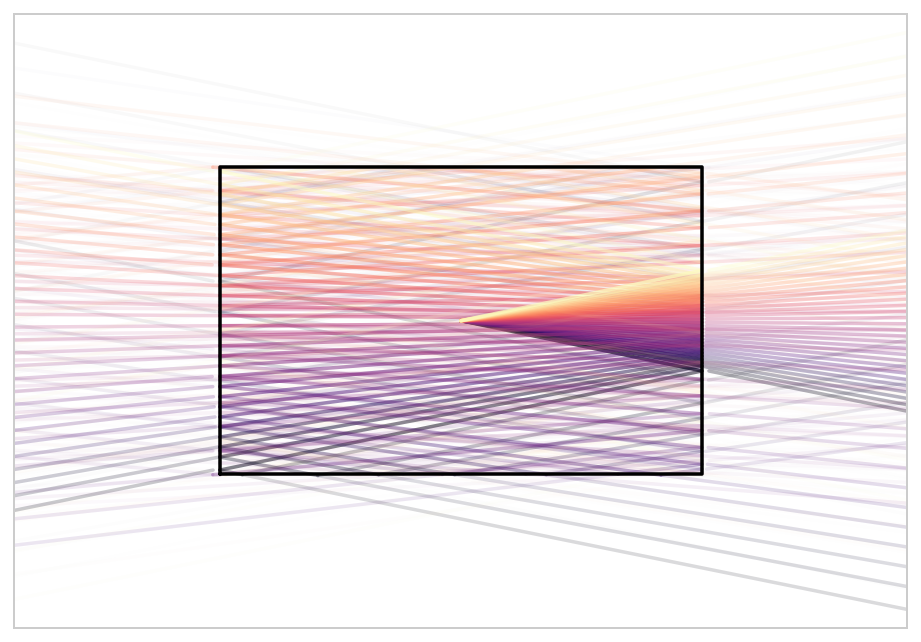

In [134]:
# Make angular range plot
totalpowerL, totalpowerR, totalpowerU, totalpowerD, f = simulateCrystal(np.linspace(-0.2, 0.2, 30), 0.7, w=np.pi/2)
plt.show()

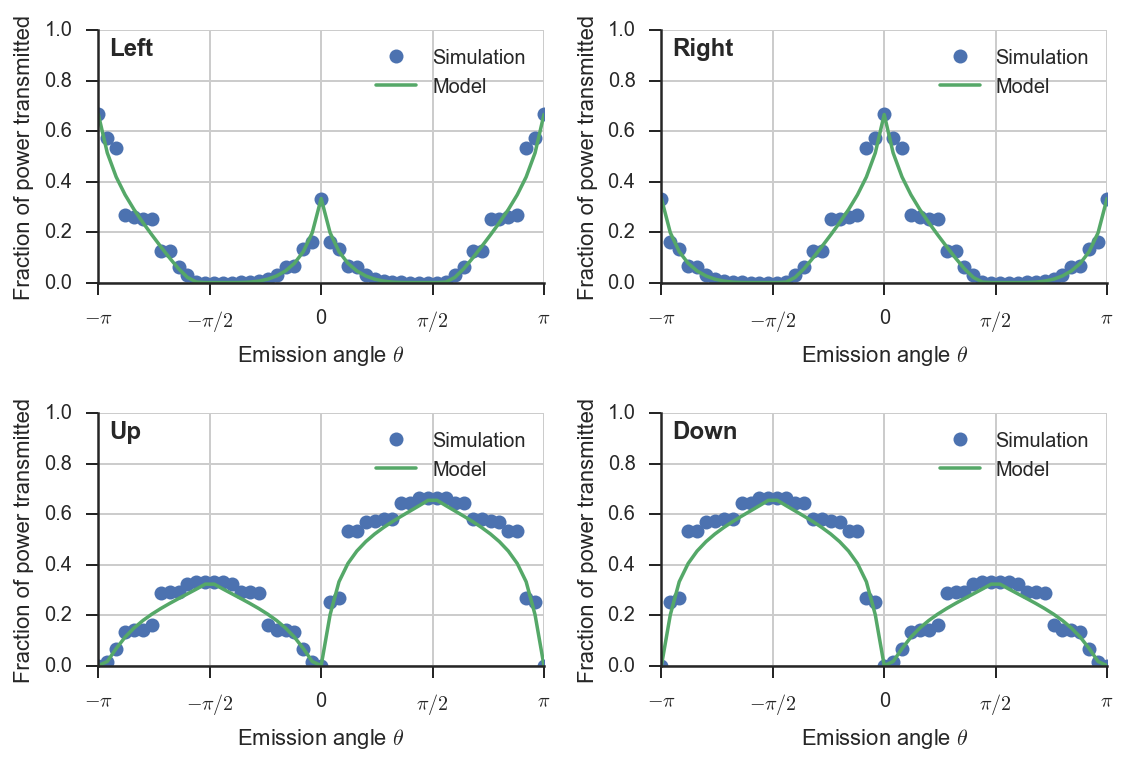

In [389]:
def plotModelComparison(R, w):
    thetas = np.linspace(-np.pi, np.pi, 51)
    pL, pR, pU, pD, f = simulateCrystal(thetas, R=R, w=w, plotflag=0)
    mL, mR, mU, mD = rectModel(thetas, R=R, w=w)
    f, ax = plt.subplots(2,2)
    for p, m, a, t in zip([pL, pR, pU, pD], [mL, mR, mU, mD], ax.ravel(), ['Left', 'Right', 'Up', 'Down']):

        plt.sca(a)
        
        plt.plot(thetas, p, 'o', label='Simulation')
        plt.plot(thetas, m, label='Model')

        plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
        plt.xlabel('Emission angle $\\theta$')
        plt.ylabel('Fraction of power transmitted')
        plt.xlim(-np.pi, np.pi)
        plt.ylim(0, 1)
        sns.set_style('ticks')
        sns.despine()
        plt.grid('on')
        plt.text(-0.95*np.pi, 0.9, t, fontweight='bold')
        plt.legend()
    plt.tight_layout()
    return f

f = plotModelComparison(R=0.5, w=3)
f.savefig('ModelComparison.png', dpi=150)
plt.close(f)
plt.show()

In [220]:
# Make animated comparison plots
Rs = np.linspace(0.1, 0.9, 100)
for R in Rs:
    f = plotModelComparison(R=R, w=3)
    fname = '{:05d}'.format(int(100*R)) + '.png'
    f.savefig(fname)
    plt.close(f)

In [ ]:
# Loop over R and w
thetas = np.linspace(-np.pi, np.pi, 51)

Nr, Nw = 10, 11
Rs = np.linspace(0.1, 0.9, Nr)
ws = np.linspace(1.0, 5.0, Nw)

fL = np.zeros((Nr, Nw))
fR = np.zeros((Nr, Nw))
fU = np.zeros((Nr, Nw))
fD = np.zeros((Nr, Nw))

for iR, R in enumerate(Rs):
    print(iR)
    for iw, w in enumerate(ws):
        pL, pR, pU, pD, f = simulateCrystal(thetas, R=R, w=w, plotflag=0)
        fL[iR, iw] = np.trapz(pL/(2*np.pi), thetas)
        fR[iR, iw] = np.trapz(pR/(2*np.pi), thetas)
        fU[iR, iw] = np.trapz(pU/(2*np.pi), thetas)
        fD[iR, iw] = np.trapz(pD/(2*np.pi), thetas)

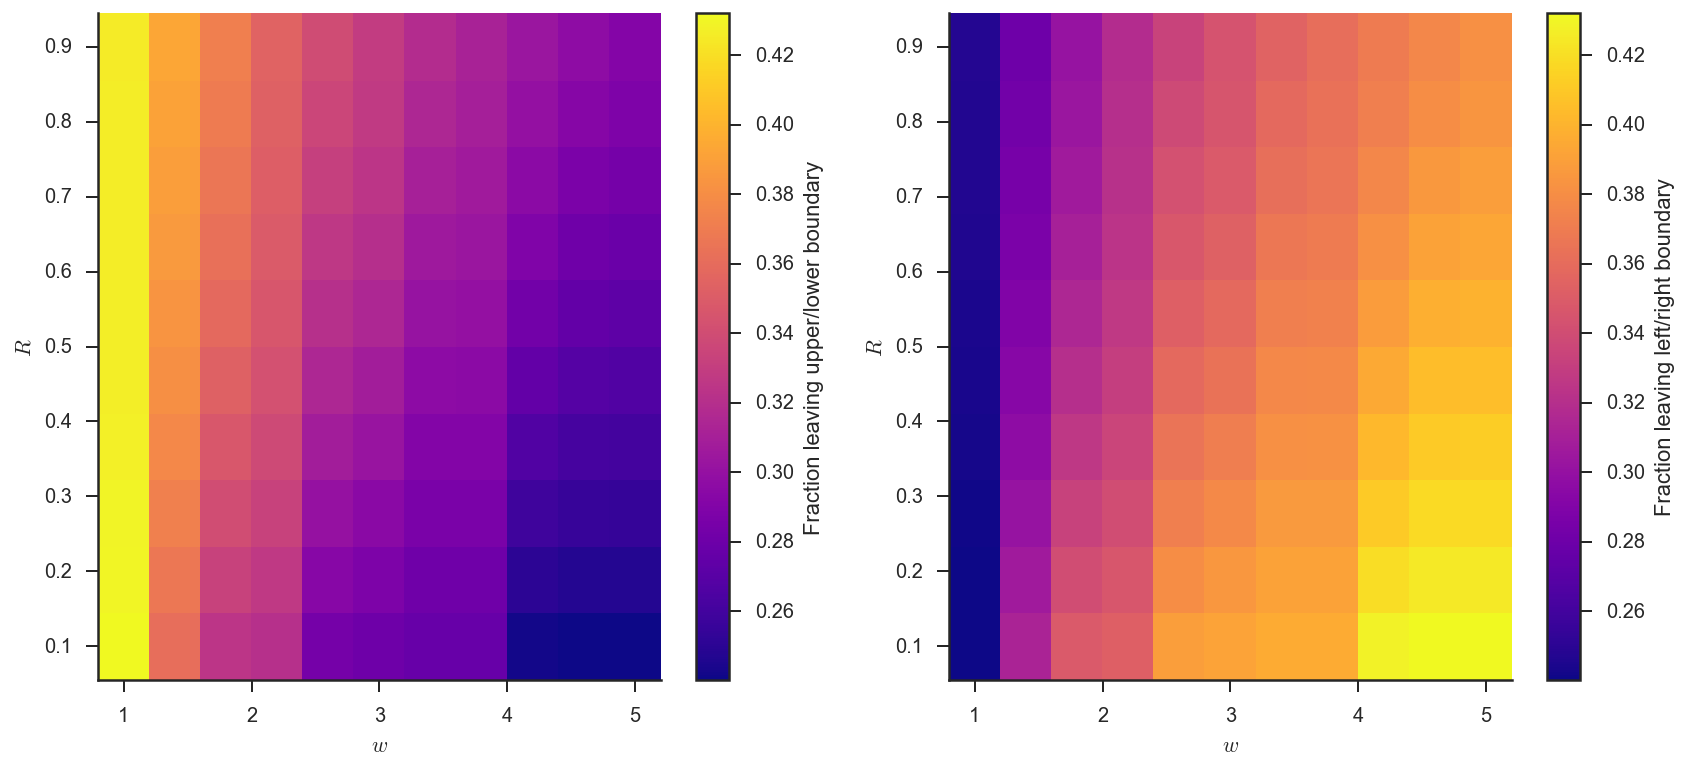

In [284]:
# Make heatmaps
Nr, Nw = 10, 11
Rs = np.linspace(0.1, 0.9, Nr)
ws = np.linspace(1.0, 5.0, Nw)

dw = ws[1] - ws[0]
ws = np.append(ws, [ws[-1]+dw])
ws -= dw/2

dR = Rs[1] - Rs[0]
Rs = np.append(Rs, Rs[-1]+dR)
Rs -= dR/2

f, ax = plt.subplots(1,2,figsize=(12,5.5))
plt.sca(ax[0])
plt.pcolor(ws, Rs, fL, cmap='plasma')
plt.xlim(ws[0], ws[-1])
plt.ylim(Rs[0], Rs[-1])
sns.despine()
plt.xlabel('$w$')
plt.ylabel('$R$')

plt.sca(ax[1])
plt.pcolor(ws, Rs, fU, cmap='plasma')
plt.xlim(ws[0], ws[-1])
plt.ylim(Rs[0], Rs[-1])
sns.despine()
plt.xlabel('$w$')
plt.ylabel('$R$')

plt.colorbar(ax=ax[0], label='Fraction leaving upper/lower boundary')
plt.colorbar(ax=ax[1], label='Fraction leaving left/right boundary')

plt.tight_layout()
f.savefig('SidevsUpper.png')
plt.show()

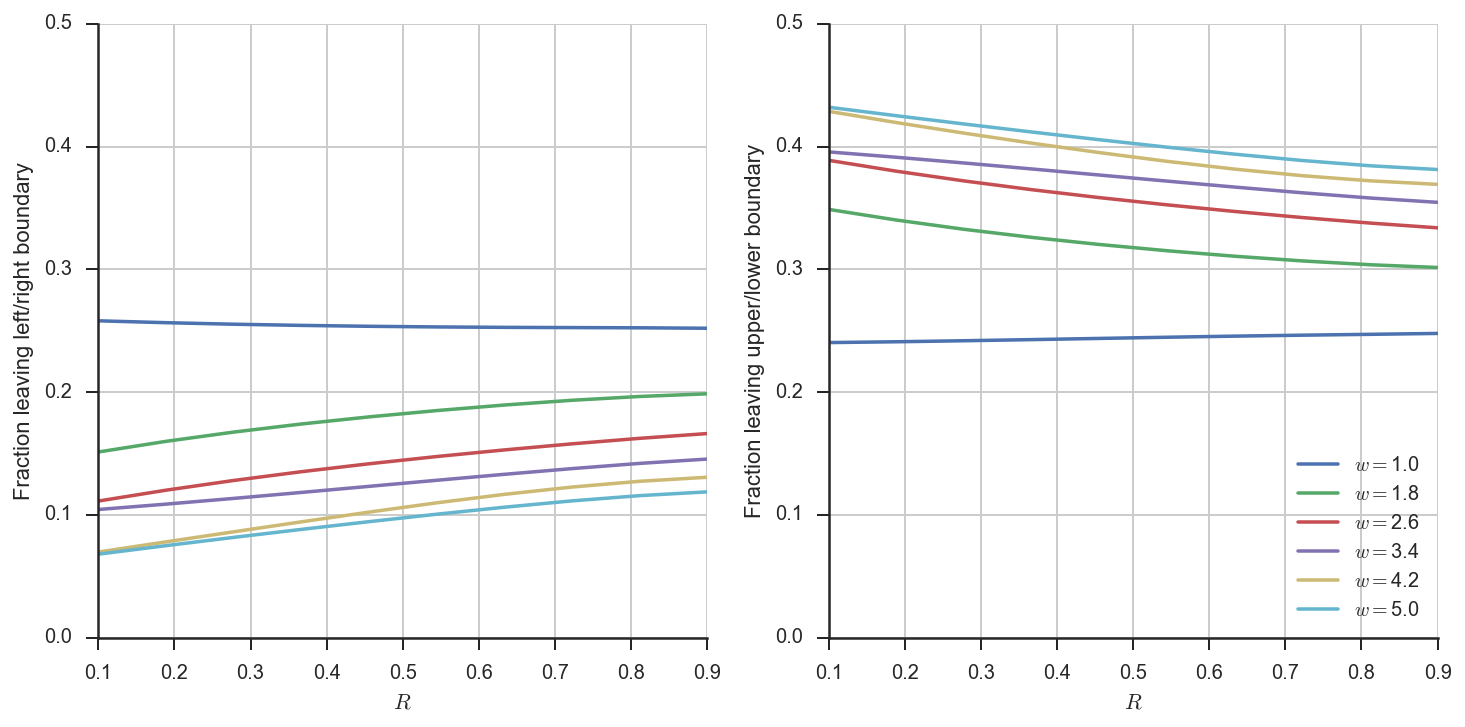

In [309]:
# Make line plots
Nr, Nw = 10, 11
Rs = np.linspace(0.1, 0.9, Nr)
ws = np.linspace(1.0, 5.0, Nw)
toplot = [0, 2, 4, 6, 8, 10]

f, ax = plt.subplots(1,2,figsize=(12,5.5))

plt.sca(ax[0])
for t in toplot:
    plt.plot(Rs, fL[:,t], label='$w = $' + str(ws[t]))
sns.despine()
plt.grid('on')

plt.xlim(0.1, 0.9)
plt.ylim(0, 0.5)
plt.xlabel('$R$')
plt.ylabel('Fraction leaving left/right boundary')

plt.sca(ax[1])
for t in toplot:
    plt.plot(Rs, fU[:,t], label='$w = $' + str(ws[t]))
sns.despine()
plt.grid('on')
plt.xlim(0.1, 0.9)
plt.ylim(0, 0.5)
plt.xlabel('$R$')
plt.ylabel('Fraction leaving upper/lower boundary')
plt.legend(loc=4)
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in double_scalars


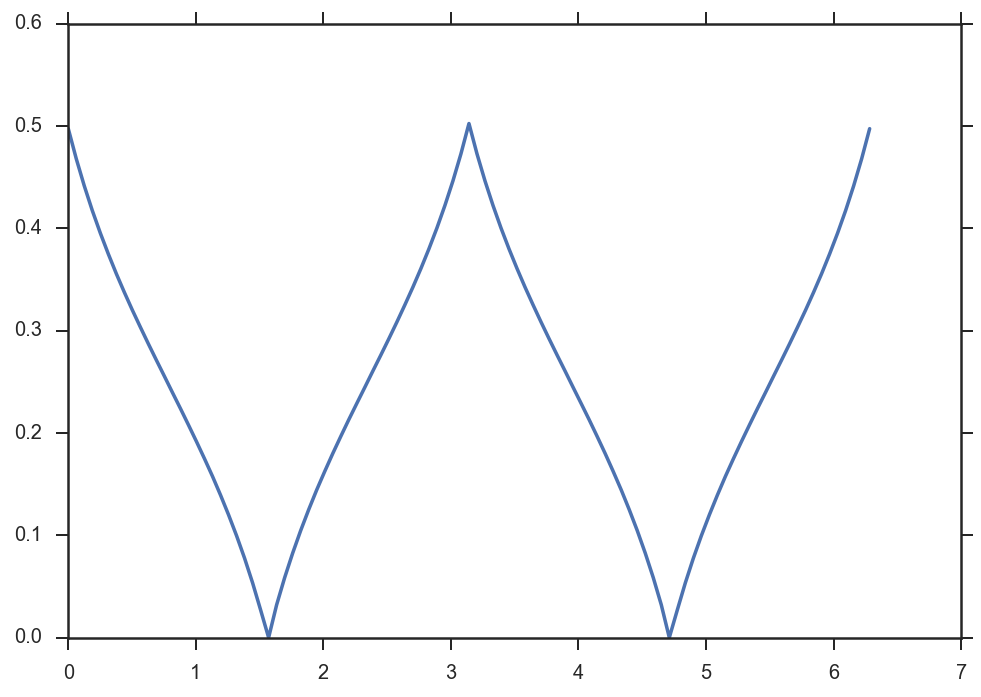

In [390]:
# Define a faster simulation
def simulateCrystalFast(thetas, R, w, plotflag=1):
    
    totalpowerL = np.zeros_like(thetas)
    totalpowerR = np.zeros_like(thetas)
    totalpowerU = np.zeros_like(thetas)
    totalpowerD = np.zeros_like(thetas)
    
    if plotflag:
        f, ax = plt.subplot(1)
    else:
        f = None
    
    for ith, theta in enumerate(thetas):
        x, y = 0, 0
        power = 1
        xvec = [x]
        yvec = [y]
        pL, pR, pU, pD = 0, 0, 0, 0

        while power > 1e-5:
            yR = y + np.tan(theta)*(w - x)
            yL = y + np.tan(theta)*(-w - x)
            xU = x + (1/np.tan(theta))*(1 - y)
            xD = x + (1/np.tan(theta))*(-1 - y)

            if np.abs(yL) < 1 and np.cos(theta) < 0:
                theta = np.pi - theta
                x = -w
                y = yL
                pL += power*(1-R)
            elif np.abs(yR) < 1  and np.cos(theta) > 0:
                theta = np.pi - theta
                x = w
                y = yR
                pR += power*(1-R)
            elif np.abs(xU) < w and np.sin(theta) > 0:
                theta *= -1
                x = xU
                y = 1
                pU += power*(1-R)
            elif np.abs(xD) < w and np.sin(theta) < 0:
                theta *= -1
                x = xD
                y = -1
                pD += power*(1-R)
            power *= R
            xvec.append(x)
            yvec.append(y)
        
        totalpowerL[ith] = pL
        totalpowerR[ith] = pR
        totalpowerU[ith] = pU
        totalpowerD[ith] = pD
        
        if plotflag:
            plt.plot(xvec, yvec)
    
    return totalpowerL, totalpowerR, totalpowerU, totalpowerD, f

thetas = np.linspace(0, 2*np.pi, 101)
R = 0.99
w = 1
totalpowerL, totalpowerR, totalpowerU, totalpowerD, f = simulateCrystalFast(thetas, R, w, plotflag=0)
plt.plot(thetas, totalpowerL)
plt.show()

In [375]:
# Vary R and w with fast model
thetas = np.linspace(-np.pi, np.pi, 101)

Nr, Nw = 20, 21
Rs = np.linspace(0, 0.95, Nr)
ws = np.linspace(0.0, 5.0, Nw)

fL = np.zeros((Nr, Nw))
fR = np.zeros((Nr, Nw))
fU = np.zeros((Nr, Nw))
fD = np.zeros((Nr, Nw))

for iR, R in enumerate(Rs):
    print(iR)
    for iw, w in enumerate(ws):
        totalpowerL, totalpowerR, totalpowerU, totalpowerD, f = simulateCrystalFast(thetas, R, w, plotflag=0)
        fL[iR, iw] = np.trapz(totalpowerL, thetas)/(2*np.pi)
        fR[iR, iw] = np.trapz(totalpowerR, thetas)/(2*np.pi)
        fU[iR, iw] = np.trapz(totalpowerU, thetas)/(2*np.pi)
        fD[iR, iw] = np.trapz(totalpowerD, thetas)/(2*np.pi)

0
1
2

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars



3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


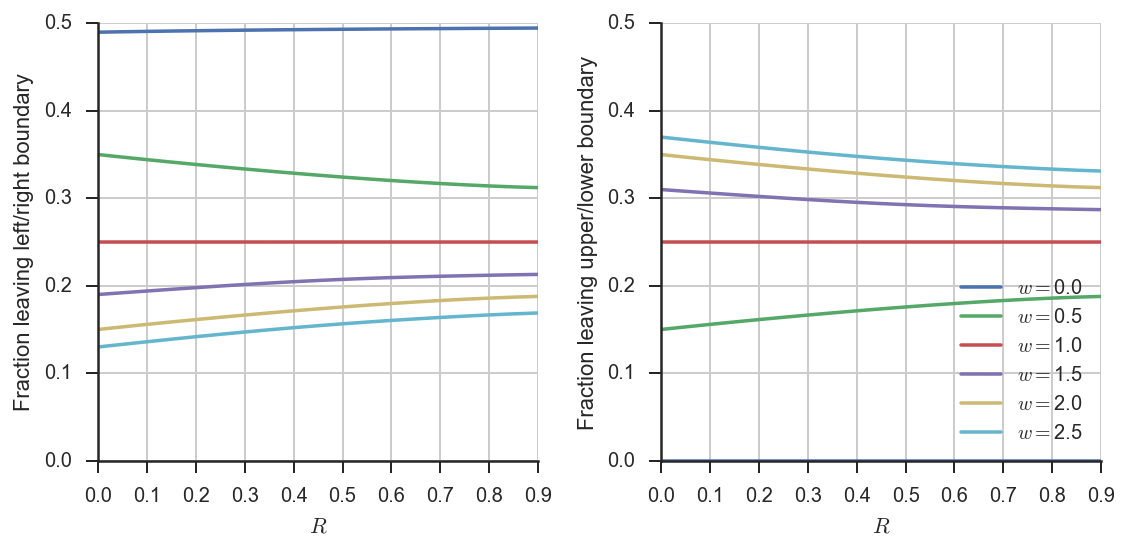

In [376]:
# Make plots with fast model
f, ax = plt.subplots(1,2,figsize=(8,4))

plt.sca(ax[0])
for t in toplot:
    plt.plot(Rs, fL[:,t], label='$w = $' + str(ws[t]))
sns.despine()
plt.grid('on')

plt.xlim(0, 0.9)
plt.ylim(0, 0.5)
plt.xlabel('$R$')
plt.ylabel('Fraction leaving left/right boundary')

plt.sca(ax[1])
for t in toplot:
    plt.plot(Rs, fU[:,t], label='$w = $' + str(ws[t]))
sns.despine()
plt.grid('on')
plt.xlim(0, 0.9)
plt.ylim(0, 0.5)
plt.xlabel('$R$')
plt.ylabel('Fraction leaving upper/lower boundary')
plt.legend(loc=4)
plt.tight_layout()
#f.savefig('Rvsw.png', dpi=120)
plt.show()

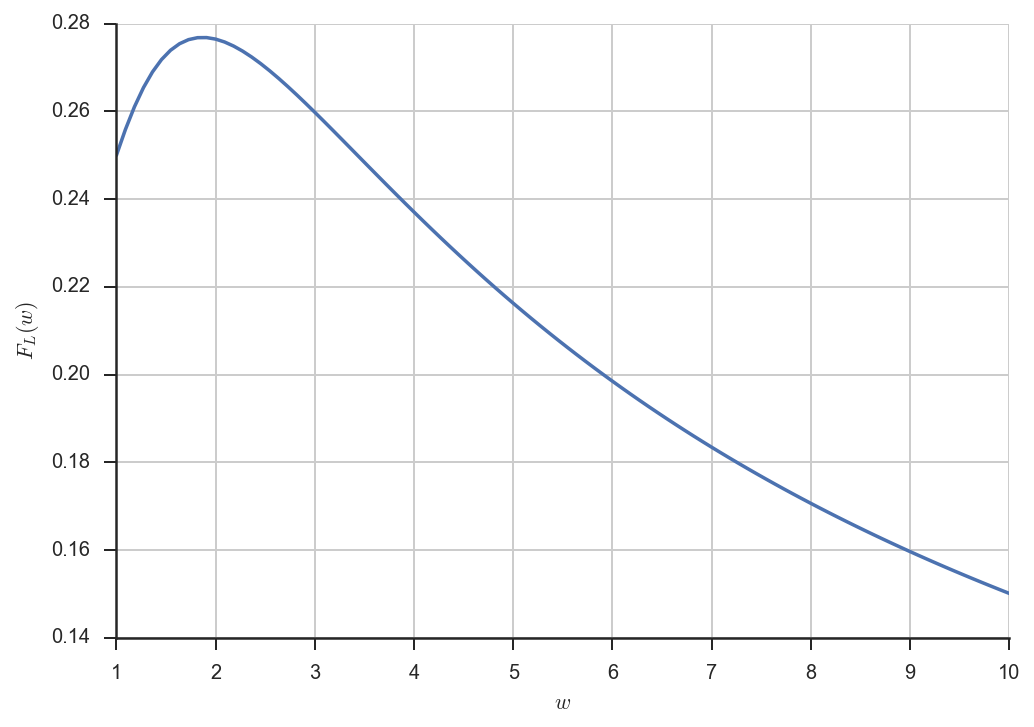

In [392]:
# Plot F_L(w)
w = np.linspace(1, 10, 100)

FL = (1 + (4/np.pi)*w*np.log(w))/(2 + 2*w**2)
plt.plot(w, FL)

sns.despine()
plt.grid('on')
plt.xlim(1, 10)
plt.xlabel('$w$')
plt.ylabel('$F_L(w)$')
plt.savefig('FLw.png')
plt.show()